# Taylor Swift Lyric Generation

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
import keras

Using TensorFlow backend.


## Importing the data

In [2]:
lyrics_dataframe = pd.read_csv("taylor_swift_lyrics.csv")
lyrics_dataframe

,Artist,Album,Song,Track_Number,Lyrics,Line_Number,Year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006
...,...,...,...,...,...,...,...
4857,Taylor Swift,reputation,New Year's Day,15,"(Hold on to the memories, they will hold on to...",43,2017
4858,Taylor Swift,reputation,New Year's Day,15,Please don't ever become a stranger,44,2017
4859,Taylor Swift,reputation,New Year's Day,15,"(Hold on to the memories, they will hold on to...",45,2017
4860,Taylor Swift,reputation,New Year's Day,15,Whose laugh I could recognize anywhere,46,2017


## Initial Data Exploration and Preprocessing
Lets poke around at the data and learn about. One of the first things we should probably figure out is how many albums and songs we are looking at

In [3]:
# Counting the number of albums
num_albums = lyrics_dataframe["Album"].drop_duplicates().size
# Counting the number of songs
num_songs = lyrics_dataframe["Song"].drop_duplicates().size
print("Number of albums : " + str(num_albums))
print("Number of songs  : " + str(num_songs))

Number of albums : 6
Number of songs  : 94


Before we go father, it might be useful to preprocess the lyrics with a function

In [4]:
# let's first build a preprocessing function which we can make adjustments to later
def preprocessLyric(line):
    # Set the line to lowercase
    line = line.lower()
    # Get rid of the parenthesis
    parenthesisopen = re.findall('\(',line)
    parenthesisclose = re.findall('\)',line)
    for i in parenthesisopen:
        line = line.replace(i, "")
    for i in parenthesisclose:
        line = line.replace(i,"")
    # Get rid of quotation marks and apostrophes
    quotes = re.findall('\"', line)
    apostrophes = re.findall("\'", line)
    for i in quotes:
        line = line.replace(i,"")
    for i in apostrophes:
        line = line.replace(i,"")
    # Make sure there is a space between words and punctuation so they dont get combined
    punc = re.findall("[!,?.]", line)
    for i in punc:
        line = line.replace(i," " + i[0] + " ")
    # Just for sanity check let's lastly get rid of the double spaces
    line = line.replace("  ", " ")
    return line

In [5]:
# Now let's apply the function to the lyrics
lyrics_dataframe["Lyrics"] = lyrics_dataframe["Lyrics"].apply(preprocessLyric)
# Let's see our changes
lyrics_dataframe

,Artist,Album,Song,Track_Number,Lyrics,Line_Number,Year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,he said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,put those georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"i said , thats a lie",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,just a boy in a chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,that had a tendency of gettin stuck,5,2006
...,...,...,...,...,...,...,...
4857,Taylor Swift,reputation,New Year's Day,15,"hold on to the memories , they will hold on to...",43,2017
4858,Taylor Swift,reputation,New Year's Day,15,please dont ever become a stranger,44,2017
4859,Taylor Swift,reputation,New Year's Day,15,"hold on to the memories , they will hold on to...",45,2017
4860,Taylor Swift,reputation,New Year's Day,15,whose laugh i could recognize anywhere,46,2017


Let's combine all the lyrics together to get an array to do some more data exploration

In [6]:
# Let's get an array of all the strings
all_lyrics = lyrics_dataframe["Lyrics"].array
# Now combine them into one large string
all_lyrics = " ".join(all_lyrics)
# Make sure there are no double spaces
all_lyrics.replace("  ", " ")
# Now break it into a list
all_lyrics = all_lyrics.split(" ")
# convert to array
#all_lyrics = np.asarray(all_lyrics)

Let's look at some of the most common words in Taylor Swift's Music

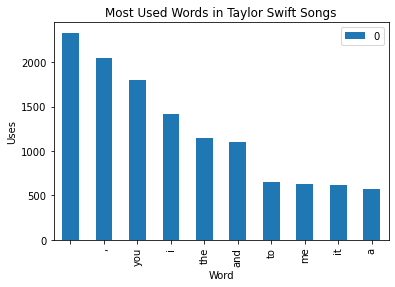

In [7]:
word_counts = Counter(all_lyrics)
word_counts_shortened = dict(word_counts.most_common(10))
df = pd.DataFrame.from_dict(word_counts_shortened, orient='index')
ax = df.plot(kind='bar', title  = "Most Used Words in Taylor Swift Songs")
_ = ax.set(xlabel='Word', ylabel='Uses')

Hmmm... This doesn't look all too interesting now does it? These are all just really common words. These are also known as stop words. One thing we can do is get rid of all these stop words, something really easy to do if you have a list of stopwords luckily we have stopwords.txt

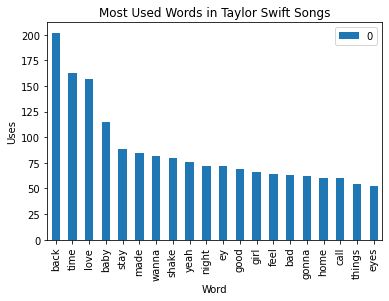

In [8]:
# Let's load all the words from the txt
file = open('stopwords_en.txt', mode = 'r')
stopwords = file.read()
file.close()
# split them into a list
stopwords = stopwords.split('\n')
# remove them from the dictionary
for i in stopwords:
    if i in word_counts.keys():
        word_counts.pop(i)
# plot the frequency once more
new_word_counts_shortened = dict(word_counts.most_common(20))
df = pd.DataFrame.from_dict(new_word_counts_shortened, orient='index')
ax = df.plot(kind='bar', title  = "Most Used Words in Taylor Swift Songs")
_ = ax.set(xlabel='Word', ylabel='Uses')

There we go, that looks a lot better. Now this looks a lot more interesting

## Model Building
Let's start building the model, first we are going to need to tokenize our input

In [9]:
# First we converted the series dataframe to a numpy
lyrics = lyrics_dataframe["Lyrics"].to_numpy()
# create the tokenizer
tokenizer = Tokenizer()
# fits the input to the text, ie the most common words closer to 0 and more obscure being farther away
tokenizer.fit_on_texts(lyrics)
# converts the input to token indicies
lyric_tokens = tokenizer.texts_to_sequences(lyrics)
# get largest list of words
maxLen = max([len(s.split()) for s in lyrics])
# padding so all inputs are the same size, padding at the end
lyric_tokens_pad = pad_sequences(lyric_tokens, maxlen = maxLen, padding = 'post')

Next we are going to create our labels which is going to just be the exact same as the input, except one moved to the left

In [10]:
# set the label = input
label = lyric_tokens_pad
# delete the first index of each array
#label = np.delete(label,0,1)
# add a zero to the end
#label = np.append(label,np.zeros((label.shape[0],1)), axis = 1)

Next we load in the embedding vectors for the words so the model knows what the words mean a bit better

In [11]:
# ##Loading in Embedding dims  dimensional
# dims = 50
# embeddings = {}
# dims = 200 # either 25, 50, 100, or 200
# with open("glove.6B/glove.6B." + str(dims) + "d.txt", encoding = "utf8")  as file:
# # Word Embeddings gotten from the twitter pre-trained vector at https://nlp.stanford.edu/projects/glove/
#     for line in file:
#         word, coefficients = line.split(maxsplit = 1)
#         coefficients = coefficients.split(" ")
#         coefficients = np.array(coefficients, dtype=np.float32)
#         embeddings[word] = coefficients

Now we make the embedding matrix using our vectors

In [12]:
# #time to make the embedding matrix
# #instantiate embedding matrix of zeroes
# embedding_matrix = np.zeros((len(tokenizer.word_index)+1, dims))
# #go through each word in the token list
# for word, i in tokenizer.word_index.items():
#     #get the corresponding embedding vector (if it exists)
#     embedding_vector = embeddings.get(word)
#     #check if its not none
#     if embedding_vector is not None:
#         #add that to the embedding matrix
#         embedding_matrix[i] = embedding_vector

In [13]:
class My_Custom_Generator(keras.utils.Sequence) :
    
    def __init__(self, lyric_indices, label_indices, num_words, batch_size) :
        self.lyric_indices = lyric_indices
        self.label_indices = label_indices
        self.num_words = num_words
        self.batch_size = batch_size
        
    def __len__(self) :
        return (np.ceil((self.lyric_indices.shape[0]) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        batch_x = self.lyric_indices[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.label_indices[idx * self.batch_size : (idx+1) * self.batch_size]
        return (to_categorical(batch_x,num_classes = num_words), to_categorical(batch_y,num_classes = num_words))

In [14]:
batch_size = 10
num_words = len(tokenizer.get_config()["word_counts"])
label = np.delete(lyric_tokens_pad,0,0)
lyric_tokens_pad = np.delete(lyric_tokens_pad,lyric_tokens_pad.shape[0]-1,0)
training_batch_generator = My_Custom_Generator(lyric_tokens_pad, label, num_words, batch_size)

In [18]:
LineGenModel = Sequential()
LineGenModel.add(
    LSTM(
        units = maxLen,
        return_sequences = True,
        input_shape = (maxLen,num_words)
    )
)
LineGenModel.add(
    LSTM(
        units = maxLen,
        return_sequences = True,
        input_shape = (maxLen,num_words)
    )
)
LineGenModel.add(
    Dense(
        maxLen * 10,
        activation = 'softmax'
    )
)
LineGenModel.add(
    Dense(
        num_words,
        activation = 'softmax'
    )
)
LineGenModel.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
LineGenModel.build((maxLen,num_words))
LineGenModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 21, 21)            2621472   
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 21)            3612      
_________________________________________________________________
dense_3 (Dense)              (None, 21, 210)           4620      
_________________________________________________________________
dense_4 (Dense)              (None, 21, 31186)         6580246   
Total params: 9,209,950
Trainable params: 9,209,950
Non-trainable params: 0
_________________________________________________________________


In [19]:
LineGenModel.fit(x = training_batch_generator,epochs = 10)

Epoch 1/10
487/487 [==============================] - 367s 754ms/step - loss: 9.3407
Epoch 2/10
487/487 [==============================] - 345s 709ms/step - loss: 7.5364
Epoch 3/10
487/487 [==============================] - 397s 815ms/step - loss: 6.1638
Epoch 4/10
487/487 [==============================] - 427s 877ms/step - loss: 5.0395
Epoch 5/10
487/487 [==============================] - 375s 770ms/step - loss: 4.1304
Epoch 6/10
487/487 [==============================] - 424s 871ms/step - loss: 3.4504
Epoch 7/10
487/487 [==============================] - 416s 854ms/step - loss: 3.0388
Epoch 8/10
487/487 [==============================] - 392s 805ms/step - loss: 2.8499
Epoch 9/10
487/487 [==============================] - 436s 895ms/step - loss: 2.7756
Epoch 10/10
487/487 [==============================] - 455s 934ms/step - loss: 2.7261


In [22]:
cat = to_categorical(lyric_tokens_pad[1],num_words).reshape((1,21,31186))
prediction = LineGenModel.predict(cat)[0]
np.argmax(prediction,axis = 1)

array([191, 7, 21, 5, 75, 98, 45, 23, 66, 78, 59, 10, 37, 24, 80, 0, 0, 0, 0, 0, 0],
      dtype=int64)